# Dataloader initialization

In [1]:
%run review/__common.py
%load_ext autoreload
%autoreload 2

[W1221 16:23:01.104503840 Utils.hpp:135] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())


---
## Dataloder initialization

Although main() defines its own dataloader on [1] - this is not used until a second phase of training.

```python
def main(cfg: DictConfig) -> None:
    ...
    if cfg.synthetic_dataset:
        ...
    else:
        DataPipe = ERA5HDF5Datapipe
    ...
```

The training starts instead with the dataloder defined in the `GraphCastTrainer` constructor [2]:

```python
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        # instantiate the training datapipe
        DataPipe = (
            SyntheticWeatherDataLoader if cfg.synthetic_dataset else ERA5HDF5Datapipe
        )
        self.interpolation_type = (
            "INTERP_LINEAR" if cfg.latlon_res != (721, 1440) else None
        )  # interpolate if not in native resolution
        self.cos_zenith_args = {
            "dt": cfg.dt,
            "start_year": cfg.start_year,
        }
        ...
        self.datapipe = DataPipe(
            data_dir=to_absolute_path(os.path.join(cfg.dataset_path, "train")),
            stats_dir=to_absolute_path(os.path.join(cfg.dataset_path, "stats")),
            channels=self.channels_list,
            latlon_resolution=cfg.latlon_res,
            interpolation_type=self.interpolation_type,
            num_samples_per_year=cfg.num_samples_per_year_train,
            num_steps=1,
            num_history=cfg.num_history,
            use_cos_zenith=cfg.use_cos_zenith,
            use_time_of_year_index=cfg.use_time_of_year_index,
            cos_zenith_args=self.cos_zenith_args,
            batch_size=1,
            num_workers=cfg.num_workers,
            device=dist.device,
            process_rank=dist.rank,
            world_size=dist.world_size,
        )
```

In a later phase of the training this gets replaced with the one defined in main() (see above):

```python
def main(cfg: DictConfig) -> None:
    ...
    with torch.autograd.profiler.emit_nvtx() if cfg.profile else nullcontext():
        while True:
            for _, data in enumerate(trainer.datapipe):
                ...
                if update_dataloader:
                    trainer.datapipe = DataPipe(
                        ...
                    )
```

Both dataloaders are based on `ERA5HDF5Datapipe`. I will analyse the first configuration first (the one in the `GraphCastTrainer` init), yet I will need to understand if/the difference afterwards. #TODO

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_graphcast.py#L360
- [2] https://vscode.dev/github.com/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_graphcast.py#L180

In [4]:
from modulus.datapipes.climate import ERA5HDF5Datapipe, SyntheticWeatherDataLoader

DataPipe = ERA5HDF5Datapipe

interpolation_type = (
    "INTERP_LINEAR" if cfg.latlon_res != (721, 1440) else None
)  # interpolate if not in native resolution
cos_zenith_args = {
    "dt": cfg.dt,
    "start_year": cfg.start_year,
}
interpolation_type, cos_zenith_args

(None, {'dt': 6.0, 'start_year': 2014})

- Interpolation is not used.
- The cos_zenith_args are to (later) compute the solar radiation, where 6.0 represents the time steps in hours and 2014 the first year of data for this (development) dataset.

It is not clear what the `stats` path is for. #TODO

In [5]:
datapipe = DataPipe(
    data_dir=to_absolute_path(os.path.join(cfg.dataset_path, "train")),
    stats_dir=to_absolute_path(os.path.join(cfg.dataset_path, "stats")),
    channels=channels_list, # self.channels_list,
    latlon_resolution=cfg.latlon_res,
    interpolation_type=interpolation_type, # self.interpolation_type,
    num_samples_per_year=cfg.num_samples_per_year_train,
    num_steps=1,
    num_history=cfg.num_history,
    use_cos_zenith=cfg.use_cos_zenith,
    use_time_of_year_index=cfg.use_time_of_year_index,
    cos_zenith_args=cos_zenith_args, # self.cos_zenith_args,
    batch_size=1,
    num_workers=cfg.num_workers,
    device=dist.device,
    process_rank=dist.rank,
    world_size=dist.world_size,
)

[16:10:36 - INFO] ERA5 file found: /mnt/data-slow/data/FCN_ERA5_data_v0/train/2014.h5
[16:10:36 - INFO] ERA5 file found: /mnt/data-slow/data/FCN_ERA5_data_v0/train/2015.h5
[16:10:36 - INFO] Number of years: 2
[16:10:36 - INFO] Getting file stats from /mnt/data-slow/data/FCN_ERA5_data_v0/train/2014.h5
[16:10:36 - INFO] data_samples_per_year: 1459 = (1460 - (1 + 0) * 1) // 1) * 1
[16:10:36 - INFO] Input image shape: (721, 1440)
[16:10:36 - INFO] Number of samples/year: 1408
[16:10:36 - INFO] Number of channels available: 21


Note that this turns into that:
- `self.logger.info(f"data_samples_per_year: {data_samples_per_year} = ({a} - ({self.num_steps} + {self.num_history}) * {self.stride}) // {self.world_size}) * {self.world_size}")`
- `data_samples_per_year: 1459 = (1460 - (1 + 0) * 1) // 1) * 1`

Let's see what is inside...

In [6]:
print("datapipe length:", len(datapipe))

print("looking at the data:")

root = to_absolute_path(os.path.join(cfg.dataset_path, "train"))
files = [f"{root}/{file}" for file in os.listdir(root) if file.endswith(".h5")]

sum = 0
for path in files:
    with h5py.File(path, 'r') as h5_file:
        print("\t", path, h5_file["fields"].shape)
        sum += h5_file["fields"].shape[0]
print("\t", "total:", sum)

print(f"{cfg.num_samples_per_year_train=}", cfg.num_samples_per_year_train*len(files))

datapipe length: 2816
looking at the data:
	 /mnt/data-slow/data/FCN_ERA5_data_v0/train/2015.h5 (1460, 21, 721, 1440)
	 /mnt/data-slow/data/FCN_ERA5_data_v0/train/2014.h5 (1460, 21, 721, 1440)
	 total: 2920
cfg.num_samples_per_year_train=1408 2816


So, the configuration is reducing the number of samples loaded from file. The reason is unclear but `config.yaml` gives us:

```
# num_samples_per_year : int, optional
#    Number of samples randomly taken from each year. If None, all will be use, by default None
```

Thus they are just randomly picked. Hopefully without repetition. #TODO

----

How do the data look like?

In [7]:
for _, data in enumerate(datapipe):
    print(len(data), data[0].keys())
    print()
    for key, value in data[0].items():
        print(f"{key}:", value.shape)
    break

1 dict_keys(['time_of_year_idx', 'invar', 'outvar', 'cos_zenith'])

time_of_year_idx: torch.Size([1, 1])
invar: torch.Size([1, 21, 721, 1440])
outvar: torch.Size([1, 1, 21, 721, 1440])
cos_zenith: torch.Size([1, 2, 1, 721, 1440])


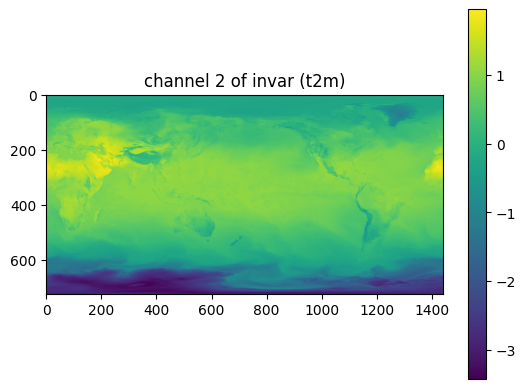

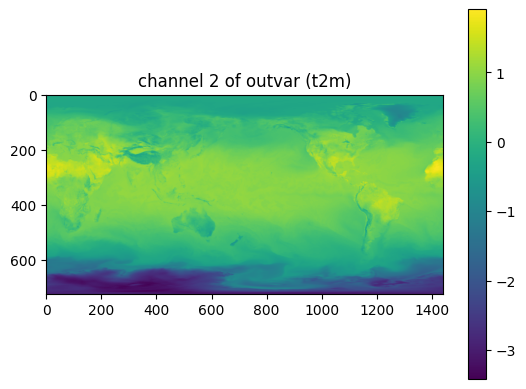

In [8]:
outvar = data[0]["outvar"]
invar = data[0]["invar"]
time_of_year_index = data[0]["time_of_year_idx"]
cos_zenith = data[0]["cos_zenith"]

plt.imshow(invar[0, 2, :, :].to("cpu"))
plt.colorbar()
plt.title("channel 2 of invar (t2m)")
plt.show()

plt.imshow(outvar[0, 0, 2, :, :].to("cpu"))
plt.colorbar()
plt.title("channel 2 of outvar (t2m)")
plt.show()

It seems the data has been standardsized or normalized (with partial stats?) in some ways.

In [9]:
time_of_year_index

tensor([[878]])

It is unclear what this represents. From config.yaml we have: `# ... the dataloader also gives the index of the sample for calculating the time of day and year progress.`

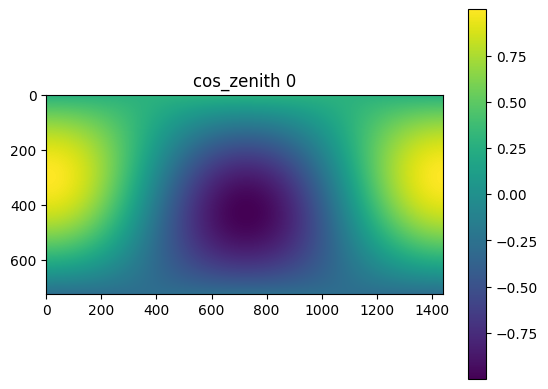

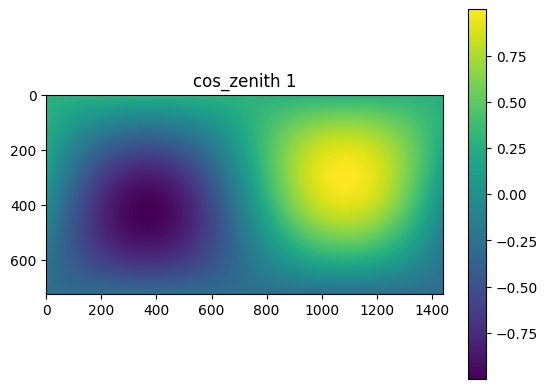

In [10]:
for i in range(2):
    plt.imshow(cos_zenith[0, i, 0, :, :].to("cpu"))
    plt.colorbar()
    plt.title(f"cos_zenith {i}")
    plt.show()

These represents the solar irradiation, thus it follows the sun. With 6h time steps, there can be 4 possibilities.

---

## How does the dataloader works internally?

The `ERA5HDF5Datapipe` class is defined in [1].

```python
class ERA5HDF5Datapipe(Datapipe):
    def __init__(...):
        ...
        self.parse_dataset_files()
        self.load_statistics()
        self.pipe = self._create_pipeline()
        ...

    def _create_pipeline(self) -> dali.Pipeline:
        ...
        pipe = dali.Pipeline(...)

        with pipe:
            source = ERA5DaliExternalSource(...)
            ...
            invar, outvar, timestamps, time_of_year_idx = dali.fn.external_source(source, ...)
            ...
            if self.stats_dir is not None:
                invar = dali.fn.normalize(invar, mean=self.mu, stddev=self.sd)
                outvar = dali.fn.normalize(outvar, mean=self.mu, stddev=self.sd)
            
            if self.use_cos_zenith:
                ...
            
            ...
            pipe.set_outputs(*outputs)
        
        return pipe    
```

From a code review of `parse_dataset_files()` and `load_statistics()` nothing complicated came up. The pipe creation depends on another class `ERA5DaliExternalSource` (a base class) defined on the same time [2].

```python
class ERA5DaliExternalSource:
    """DALI Source for lazy-loading the HDF5 ERA5 files"""
    def __init__():
        ...
        self.indices = np.arange(num_samples) # <--- "num_samples" being initialized from "self.total_length = self.n_years * self.num_samples_per_year" (L289 in ERA5HDF5Datapipe), 
                                            #      initialized itself from configs (default: 1408)
        # Shard from indices if running in parallel
        self.indices = np.array_split(self.indices, world_size)[process_rank]
        ...
        # Get number of full batches, ignore possible last incomplete batch for now.
        # Also, DALI external source does not support incomplete batches in parallel mode.
        self.num_batches = len(self.indices) // self.batch_size
```

Let's see how the code of `_create_pipeline()` works.

Comment: It seems that the data loader is written for the ERA5 dataset curated by NERSC, as it all revolves around that format and "fields" field. Nevertheless, default configs are set for 73 channels (instead of NERSC's 21).

- [1] https://vscode.dev/github.com/NVIDIA/modulus/blob/main/modulus/datapipes/climate/era5_hdf5.py#L57
- [2] https://vscode.dev/github.com/NVIDIA/modulus/blob/main/modulus/datapipes/climate/era5_hdf5.py#L460

In [11]:
import nvidia.dali as dali
from modulus.datapipes.climate.era5_hdf5 import ERA5DaliExternalSource
import nvidia.dali.plugin.pytorch as dali_pth

# mocking values
num_samples = 2 * 1408
process_rank = 0
world_size = 2
batch_size = 2

data_paths = [
    "/mnt/data-slow/data/FCN_ERA5_data_v0/train/2014.h5",
    "/mnt/data-slow/data/FCN_ERA5_data_v0/train/2015.h5"
]

pipe = dali.Pipeline(
    batch_size=batch_size,
    num_threads=2,
    prefetch_queue_depth=2,
    py_num_workers=8, # self.num_workers,
    device_id=0, # self.device.index,
    py_start_method="spawn",
)

with pipe:
    source = ERA5DaliExternalSource(
        data_paths=data_paths, # self.data_paths,
        num_samples=num_samples, # self.total_length,
        channels=channels_list, # self.channels,
        stride=1, # self.stride,
        num_steps=1, # self.num_steps,
        num_history=0, # self.num_history,
        num_samples_per_year=1408, # self.num_samples_per_year,
        use_cos_zenith=True, # self.use_cos_zenith,
        cos_zenith_args=cos_zenith_args,
        use_time_of_year_index=True, # self.use_time_of_year_index,
        batch_size=batch_size,
        shuffle=True, # self.shuffle,
        process_rank=dist.rank,
        world_size=dist.world_size,
    )

    invar, outvar, timestamps, time_of_year_idx = dali.fn.external_source(
        source,
        num_outputs=4,
        parallel=True,
        batch=False,
        layout=["CHW", "FCHW"], #self.layout,
    )

    invar, outvar, timestamps, time_of_year_idx
    invar = invar.gpu()
    outvar = outvar.gpu()
    outputs = (invar, outvar, time_of_year_idx, timestamps)
    pipe.set_outputs(*outputs)

In [12]:
pipe.reset()
output_keys = ["invar", "outvar", "time_of_year_idx", "cos_zenith"]
iterator = dali_pth.DALIGenericIterator([pipe], output_keys)

In [13]:
for data in iterator:
    print(
        data[0].keys(), 
        data[0]["invar"].shape, 
        data[0]["outvar"].shape,
        data[0]["time_of_year_idx"].shape,
        data[0]["cos_zenith"].shape
    )
    print("time_of_year_idx:", [int(v) for v in data[0]["time_of_year_idx"].flatten()])
    print("cos_zenith:", [int(v) for v in data[0]["cos_zenith"].flatten()])
    break

dict_keys(['time_of_year_idx', 'invar', 'outvar', 'cos_zenith']) torch.Size([2, 21, 721, 1440]) torch.Size([2, 1, 21, 721, 1440]) torch.Size([2, 1]) torch.Size([2, 2])
time_of_year_idx: [878, 636]
cos_zenith: [1407499200, 1407520800, 1433808000, 1433829600]


So we have that `ERA5DaliExternalSource` takes care of opening and slicing the files, and is called by the dali Pipeline who takes care of facilitating the data processing through the GPU.

The `ERA5HDF5Datapipe` returns a dali iterator that can then be used as a usual dataloader object.

---

## How do invar and outvar relate

`ERA5DaliExternalSource` is called by `dali.fn.external_source()` to pull out samples.


```python
class ERA5DaliExternalSource:
    ...
    def __init__(
        self,
        num_samples: int, # Total number of training samples, i.e. .h5 files found (assuming one per year) and the cfg.samples_per_year (default: 1408 while on file there are 1460 in each file)
        channels: Iterable[int],
        num_steps: int, # Number of timesteps are included in the output variables (default: 1)
        num_history: int, # Number of previous timesteps included in the input variables (default: 0)
        stride: int, # Number of steps between input and output variables (default: 1 = 6h)
        num_samples_per_year: int, # Number of samples randomly taken from each year (default: 1408)
        batch_size: int = 1,
    ):
        ...
        self.num_samples = num_samples
        self.chans = list(channels)
        self.num_steps = num_steps
        self.num_history = num_history
        self.stride = stride
        self.num_samples_per_year = num_samples_per_year
        ...

        self.indices = np.arange(num_samples)

        # Shard from indices if running in parallel
        self.indices = np.array_split(self.indices, world_size)[process_rank]

        # Get number of full batches, ignore possible last incomplete batch for now.
        # Also, DALI external source does not support incomplete batches in parallel mode.
        self.num_batches = len(self.indices) // self.batch_size
        ...
    
    def __call__(...) -> Tuple[Tensor, Tensor, np.ndarray]:
        ...
        # Shuffle before the next epoch starts.
        if self.shuffle and sample_info.epoch_idx != self.last_epoch:
            # All workers use the same rng seed so the resulting
            # indices are the same across workers.
            np.random.default_rng(seed=sample_info.epoch_idx).shuffle(self.indices)
            self.last_epoch = sample_info.epoch_idx
        ...
        # Get local indices from global index.
        idx = self.indices[sample_info.idx_in_epoch]
        year_idx = idx // self.num_samples_per_year
        in_idx = idx % self.num_samples_per_year
        ...
        data = self.data_files[year_idx]["fields"]
        if self.num_history == 0:
            # Has [C,H,W] shape.
            invar = data[in_idx, self.chans]
        else:
            # Has [T,C,H,W] shape.
            invar = data[in_idx : in_idx + (self.num_history + 1) * self.stride : self.stride, self.chans,]

        # Has [T,C,H,W] shape.
        outvar = np.empty((self.num_steps,) + invar.shape[-3:], dtype=invar.dtype)

        for i in range(self.num_steps):
            out_idx = in_idx + (self.num_history + i + 1) * self.stride
            outvar[i] = data[out_idx, self.chans]
        ...
```

Looking at the init:

In [14]:
# Mocking values
num_samples = 2 * 10 # 2 years in the training dataset for the development environment, times 10 or 1408 samples per year (default configuration)
#process_rank = 0 # hypotetical
world_size = 2
batch_size = 2

indices = np.arange(num_samples)
print("indices", indices, indices.shape)

indices_rank_0 = np.array_split(indices, world_size)[0]
indices_rank_1 = np.array_split(indices, world_size)[1]
print(f"indices for process_rank=0", indices_rank_0, indices_rank_0.shape)
print(f"indices for process_rank=1", indices_rank_1, indices_rank_1.shape)

num_batches_rank_0 = len(indices_rank_0) // batch_size
num_batches_rank_1 = len(indices_rank_1) // batch_size
print("num_batches_rank_0", num_batches_rank_0)
print("num_batches_rank_1", num_batches_rank_1)

indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] (20,)
indices for process_rank=0 [0 1 2 3 4 5 6 7 8 9] (10,)
indices for process_rank=1 [10 11 12 13 14 15 16 17 18 19] (10,)
num_batches_rank_0 5
num_batches_rank_1 5


Looking at the `__call__()`:

In [15]:
# mock
sample_info_epoch_idx = 12 # sample_info.epoch_idx

_indices = indices_rank_0
print("Before", _indices[:9])
if True: # self.shuffle and sample_info.epoch_idx != self.last_epoch:
    # All workers use the same rng seed so the resulting indices are the same across workers.
    np.random.default_rng(seed=sample_info_epoch_idx).shuffle(_indices)
print("After", _indices[:9])

Before [0 1 2 3 4 5 6 7 8]
After [7 1 5 0 3 4 2 6 9]


In [16]:
# mock
sample_info_idx_in_epoc = 4 # sample_info.idx_in_epoc

idx = _indices[sample_info_idx_in_epoc]
print("idx", idx)

year_idx = idx // 10 # 1408 # self.num_samples_per_year
print("year_idx", year_idx)

# invar index
in_idx = idx % 10 # 1408 # self.num_samples_per_year
print("in_idx", in_idx)

idx 3
year_idx 0
in_idx 3


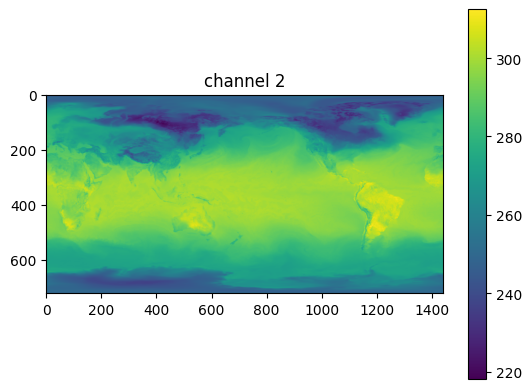

(21, 721, 1440)


In [17]:
# mocking
data_files = [h5py.File(path, "r") for path in [
    "/mnt/data-slow/data/FCN_ERA5_data_v0/train/2014.h5",
    "/mnt/data-slow/data/FCN_ERA5_data_v0/train/2015.h5"
]]
chans = list(range(21))
num_history = 0 # default

data = data_files[year_idx]["fields"]
if num_history == 0:
    # Has [C,H,W] shape.
    invar = data[in_idx, chans]
else:
    pass

plt.imshow(invar[2, :, :])
plt.colorbar()
plt.title("channel 2")
plt.show()

print(invar.shape)

```python
class ERA5DaliExternalSource:
    ...
    def __call__(...) -> Tuple[Tensor, Tensor, np.ndarray]:
        ...
        # Has [T,C,H,W] shape.
        outvar = np.empty((self.num_steps,) + invar.shape[-3:], dtype=invar.dtype)

        for i in range(self.num_steps):
            out_idx = in_idx + (self.num_history + i + 1) * self.stride
            outvar[i] = data[out_idx, self.chans]
        ...
```

In [18]:
# mock
num_steps = 1 # self.num_steps
stride = 1

(num_steps,) + invar.shape[-3:], invar.dtype

((1, 21, 721, 1440), dtype('float32'))

In [19]:
# mock
i = 0

out_idx = in_idx + (num_history + i + 1) * stride

in_idx, out_idx

(3, 4)

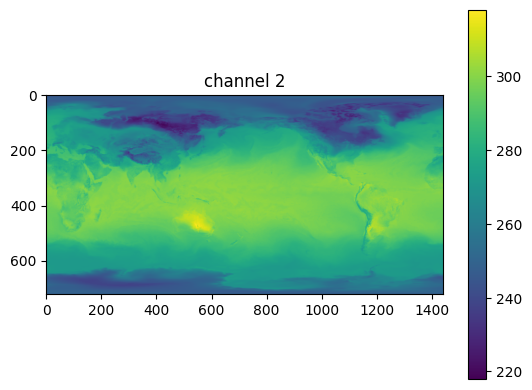

(1, 21, 721, 1440)

In [20]:
# Has [T,C,H,W] shape.
outvar = np.empty((num_steps,) + invar.shape[-3:], dtype=invar.dtype)

for i in range(num_steps):
    out_idx = in_idx + (num_history + i + 1) * stride
    outvar[i] = data[out_idx, chans]

plt.imshow(outvar[0, 2, :, :])
plt.colorbar()
plt.title("channel 2")
plt.show()

outvar.shape

Two questions: # TODO
- Given that `cfg.num_samples_per_year` is 1408 instead of 1460, thus smaller, does it mean some samples are never picked (e.g. those in late December)?
- What happens if I pick the very last index of year 0? Does it load outvar from the next year?

---
## Static data management

Subsequently in the initialization of the training routing, static data is loaded in [1].

```py
from modulus.utils.graphcast.data_utils import StaticData
...
class GraphCastTrainer(BaseTrainer):
    def __init__(self, cfg: DictConfig, dist, rank_zero_logger):
        ...
        self.model = GraphCastNet(
            ...
        )
        ...
        if hasattr(self.model, "module"):
            self.latitudes = self.model.module.latitudes
            self.longitudes = self.model.module.longitudes
            ...
        else:
            self.latitudes = self.model.latitudes
            self.longitudes = self.model.longitudes
        ...
        self.static_dataset_path = (
            to_absolute_path(cfg.static_dataset_path)
            if cfg.static_dataset_path
            else None
        )
        ...
        if self.static_dataset_path:
            self.static_data = StaticData(self.static_dataset_path, self.latitudes, self.longitudes).get()
        ...
```

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_graphcast.py#L276

The simpler arguments to make sense of are:
- `self.latutide` taking `model.latitudes` is a `tensor([-90.0000, -89.7500, -89.5000, ...,  89.5000,  89.7500,  90.0000])` of length 721
- `self.longitudes` taking `model.longitudes` is a `tensor([-179.7500, -179.5000, -179.2500,  ...,  179.5000,  179.7500, 180.0000])` of lenth 1440

... both are initialized from the model values, already analised in [02_area.ipynb](02_area.ipynb):

In [2]:
cfg.static_dataset_path, to_absolute_path(cfg.static_dataset_path)

('/mnt/data-slow/data/FCN_ERA5_data_v0/static',
 '/mnt/data-slow/data/FCN_ERA5_data_v0/static')

In [3]:
!ls -LRla /mnt/data-slow/data/FCN_ERA5_data_v0

/mnt/data-slow/data/FCN_ERA5_data_v0:
total 32
drwxr-xr-x 5 1001 1002 4096 Nov 24 12:22 .
drwxr-xr-x 5 1001 1002 4096 Nov 24 21:54 ..
-rw-r--r-- 1 1001 1002  826 Nov 18 22:24 README.md
-rw-rw-r-- 1 1001 1002  487 Dec 17 08:39 metadata.json
drwxr-xr-x 2 1001 1002 4096 Nov 30 17:41 static
drwxr-xr-x 2 1001 1002 4096 Nov 24 16:58 stats
drwxr-xr-x 2 1001 1002 4096 Nov 18 22:25 test
drwxr-xr-x 2 1001 1002 4096 Nov 18 22:25 train

/mnt/data-slow/data/FCN_ERA5_data_v0/static:
total 11460
drwxr-xr-x 2 1001 1002    4096 Nov 30 17:41 .
drwxr-xr-x 5 1001 1002    4096 Nov 24 12:22 ..
-rw-rw-r-- 1 1001 1002 2633064 Nov 30 17:12 geopotential.nc
-rw-rw-r-- 1 1001 1002  780588 Nov 30 17:03 land_sea_mask.nc
-rw-r--r-- 1 1001 1002 8307968 Nov 18 22:24 orography.h5

/mnt/data-slow/data/FCN_ERA5_data_v0/stats:
total 8148
drwxr-xr-x 2 1001 1002    4096 Nov 24 16:58 .
drwxr-xr-x 3 1001 1002    4096 Nov 18 22:23 ..
-rw-r--r-- 1 1001 1002     296 Nov 21 12:54 global_means.npy
-rw-r--r-- 1 1001 1002     296 No

The necessary files might be missing, like it was the case for the channels metadata.

Trying to make sense of what should be there I look at [1]:

```py
...
from torch.nn.functional import interpolate
...
class StaticData:
    """Class to load static data from netCDF files. Static data includes land-sea mask, geopotential, and latitude-longitude coordinates."""

    def __init__(self, static_dataset_path: str, latitudes: Tensor, longitudes: Tensor) -> None:
        self.lsm_path = os.path.join(static_dataset_path, "land_sea_mask.nc")
        self.geop_path = os.path.join(static_dataset_path, "geopotential.nc")
        self.lat = latitudes
        self.lon = longitudes

    def get_lsm(self) -> Tensor:
        """Get land-sea mask from netCDF file. Returns Tensor: Land-sea mask with shape (1, 1, lat, lon)."""
        ds = torch.tensor(nc.Dataset(self.lsm_path)["lsm"], dtype=torch.float32)
        ds = torch.unsqueeze(ds, dim=0)
        ds = interpolate(ds, size=(self.lat.size(0), self.lon.size(0)), mode="bilinear")
        return ds

    def get_geop(self, normalize: bool = True) -> Tensor:
        """Get geopotential from netCDF file. Returns Tensor: Normalized geopotential with shape (1, 1, lat, lon)."""
        ds = torch.tensor(nc.Dataset(self.geop_path)["z"], dtype=torch.float32)
        ds = torch.unsqueeze(ds, dim=0)
        ds = interpolate(ds, size=(self.lat.size(0), self.lon.size(0)), mode="bilinear")
        if normalize:
            ds = (ds - ds.mean()) / ds.std()
        return ds

    def get_lat_lon(self) -> Tensor:
        """
        Computes cosine of latitudes and sine and cosine of longitudes. 
        Returns Tensor with shape (1, 3, lat, lon) tha includes cosine of latitudes, sine and cosine of longitudes.
        """
        
        # cos latitudes
        cos_lat = torch.cos(deg2rad(self.lat))
        cos_lat = cos_lat.view(1, 1, self.lat.size(0), 1)
        cos_lat_mg = cos_lat.expand(1, 1, self.lat.size(0), self.lon.size(0))

        # sin longitudes
        sin_lon = torch.sin(deg2rad(self.lon))
        sin_lon = sin_lon.view(1, 1, 1, self.lon.size(0))
        sin_lon_mg = sin_lon.expand(1, 1, self.lat.size(0), self.lon.size(0))

        # cos longitudes
        cos_lon = torch.cos(deg2rad(self.lon))
        cos_lon = cos_lon.view(1, 1, 1, self.lon.size(0))
        cos_lon_mg = cos_lon.expand(1, 1, self.lat.size(0), self.lon.size(0))

        outvar = torch.cat((cos_lat_mg, sin_lon_mg, cos_lon_mg), dim=1)

        return outvar

    def get(self) -> Tensor:  # pragma: no cover
        """
        Get all static data.
        Return Tensor with shape (1, 5, lat, lon) that includes land-sea mask, geopotential, cosine of latitudes, sine and cosine of longitudes.
        """
        lsm = self.get_lsm()
        geop = self.get_geop()
        lat_lon = self.get_lat_lon()
        return torch.concat((lsm, geop, lat_lon), dim=1)

```

The NERSC curated files available from their Globus do not include the .nc files hardcoded in the model codebase.

I'd would rather not change the code of the library. I try to download them from CDS.

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/modulus/utils/graphcast/data_utils.py#L27

In [4]:
# mock object initialization 
lsm_path = os.path.join(cfg.static_dataset_path, "land_sea_mask.nc")
geop_path = os.path.join(cfg.static_dataset_path, "geopotential.nc")
input_res = (721, 1440)
lat = torch.linspace(-90, 90, steps=input_res[0])
lon = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]

lsm_path, geop_path, lat.shape, lon.shape

('/mnt/data-slow/data/FCN_ERA5_data_v0/static/land_sea_mask.nc',
 '/mnt/data-slow/data/FCN_ERA5_data_v0/static/geopotential.nc',
 torch.Size([721]),
 torch.Size([1440]))

Starting from `get_lsm()`

In [5]:
ds = torch.tensor(nc.Dataset(lsm_path)["lsm"], dtype=torch.float32)
ds, ds.shape

/tmp/ipykernel_1626/2164646458.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  ds = torch.tensor(nc.Dataset(lsm_path)["lsm"], dtype=torch.float32)


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 torch.Size([1, 721, 1440]))

In [28]:
# !pip uninstall -y netCDF4 h5py
!pip install -q netCDF4 h5py


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


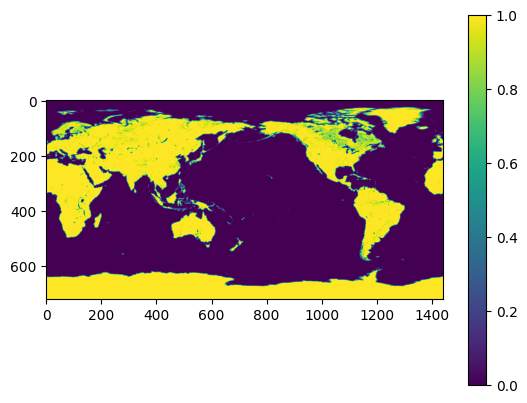

torch.Size([1, 1, 721, 1440])

In [ ]:
ds1 = torch.unsqueeze(ds, dim=0)

plt.imshow(ds1[0, 0])
plt.colorbar()
plt.show()

ds1.shape

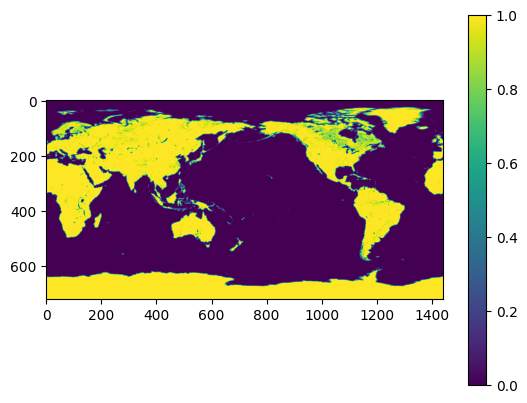

torch.Size([1, 721, 1440])

In [ ]:
from torch.nn.functional import interpolate

ds2 = interpolate(ds1, size=(lat.size(0), lon.size(0)), mode="bilinear")

plt.imshow(ds2[0, 0])
plt.colorbar()
plt.show()

ds.shape

The interpolation ensures that the last two dimensions are interpolated into the target resolution. As the resolution of the data downloaded from CDS is already the target one, this function just reshape the (1, 721, 1440) into (1, 1, 721, 1440).

The `get_geop()` function does exactly the same but also normalise values.

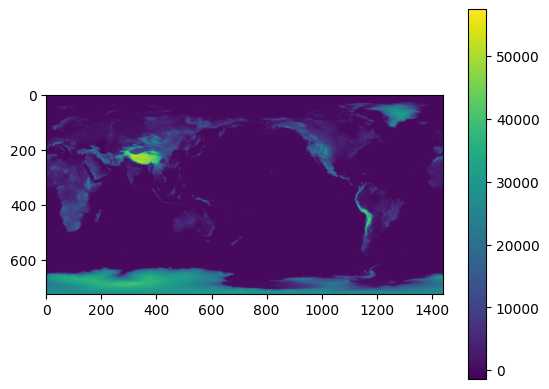

torch.Size([1, 721, 1440])

In [ ]:
ds1 = torch.tensor(nc.Dataset(geop_path)["z"], dtype=torch.float32)

plt.imshow(ds1[0])
plt.colorbar()
plt.show()

ds1.shape

In [ ]:
ds2 = torch.unsqueeze(ds1, dim=0)
ds2.shape

torch.Size([1, 1, 721, 1440])

In [ ]:
ds3 = interpolate(ds2, size=(lat.size(0), lon.size(0)), mode="bilinear")
ds3.shape

torch.Size([1, 1, 721, 1440])

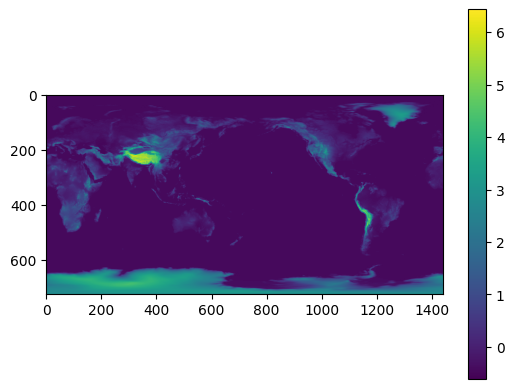

(tensor(-0.6120), tensor(6.4346))

In [ ]:
ds4 = (ds3 - ds3.mean()) / ds3.std()

plt.imshow(ds4[0, 0])
plt.colorbar()
plt.show()

ds4.min(), ds4.max()

This is standardsization, not normalization...

Lastly, `get_lat_lon()`:

In [ ]:
from modulus.utils.graphcast.graph_utils import deg2rad

cos_lat = torch.cos(deg2rad(lat))

lat[:10], lat.shape, cos_lat[:10], cos_lat.shape

(tensor([-90.0000, -89.7500, -89.5000, -89.2500, -89.0000, -88.7500, -88.5000,
         -88.2500, -88.0000, -87.7500]),
 torch.Size([721]),
 tensor([-4.3711e-08,  4.3632e-03,  8.7266e-03,  1.3090e-02,  1.7452e-02,
          2.1815e-02,  2.6177e-02,  3.0539e-02,  3.4899e-02,  3.9260e-02]),
 torch.Size([721]))

In [ ]:
cos_lat = cos_lat.view(1, 1, lat.size(0), 1)
cos_lat, cos_lat.shape

(tensor([[[[-4.3711e-08],
           [ 4.3632e-03],
           [ 8.7266e-03],
           [ 1.3090e-02],
           [ 1.7452e-02],
           [ 2.1815e-02],
           [ 2.6177e-02],
           [ 3.0539e-02],
           [ 3.4899e-02],
           [ 3.9260e-02],
           [ 4.3619e-02],
           [ 4.7978e-02],
           [ 5.2336e-02],
           [ 5.6693e-02],
           [ 6.1049e-02],
           [ 6.5403e-02],
           [ 6.9757e-02],
           [ 7.4109e-02],
           [ 7.8459e-02],
           [ 8.2808e-02],
           [ 8.7156e-02],
           [ 9.1502e-02],
           [ 9.5846e-02],
           [ 1.0019e-01],
           [ 1.0453e-01],
           [ 1.0887e-01],
           [ 1.1320e-01],
           [ 1.1754e-01],
           [ 1.2187e-01],
           [ 1.2620e-01],
           [ 1.3053e-01],
           [ 1.3485e-01],
           [ 1.3917e-01],
           [ 1.4349e-01],
           [ 1.4781e-01],
           [ 1.5212e-01],
           [ 1.5643e-01],
           [ 1.6074e-01],
           [

In [ ]:
cos_lat_mg = cos_lat.expand(1, 1, lat.size(0), lon.size(0))
cos_lat_mg, cos_lat_mg.shape

(tensor([[[[-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
            -4.3711e-08, -4.3711e-08],
           [ 4.3632e-03,  4.3632e-03,  4.3632e-03,  ...,  4.3632e-03,
             4.3632e-03,  4.3632e-03],
           [ 8.7266e-03,  8.7266e-03,  8.7266e-03,  ...,  8.7266e-03,
             8.7266e-03,  8.7266e-03],
           ...,
           [ 8.7266e-03,  8.7266e-03,  8.7266e-03,  ...,  8.7266e-03,
             8.7266e-03,  8.7266e-03],
           [ 4.3632e-03,  4.3632e-03,  4.3632e-03,  ...,  4.3632e-03,
             4.3632e-03,  4.3632e-03],
           [-4.3711e-08, -4.3711e-08, -4.3711e-08,  ..., -4.3711e-08,
            -4.3711e-08, -4.3711e-08]]]]),
 torch.Size([1, 1, 721, 1440]))

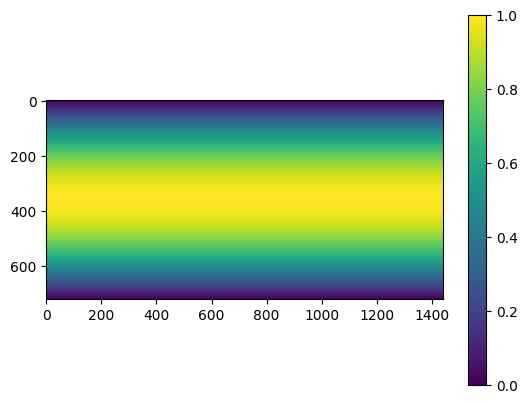

In [ ]:
plt.imshow(cos_lat_mg[0, 0])
plt.colorbar()
plt.show()

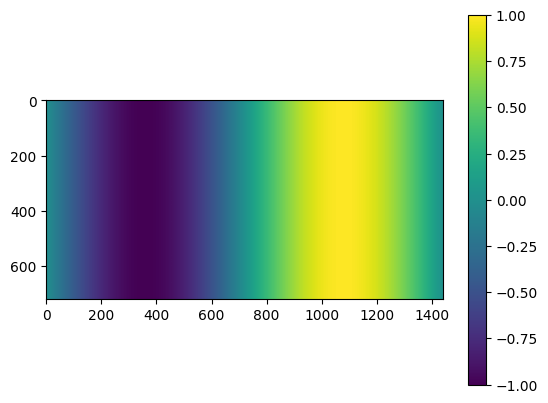

In [ ]:
sin_lon = torch.sin(deg2rad(lon))
sin_lon = sin_lon.view(1, 1, 1, lon.size(0))
sin_lon_mg = sin_lon.expand(1, 1, lat.size(0), lon.size(0))

plt.imshow(sin_lon_mg[0, 0])
plt.colorbar()
plt.show()

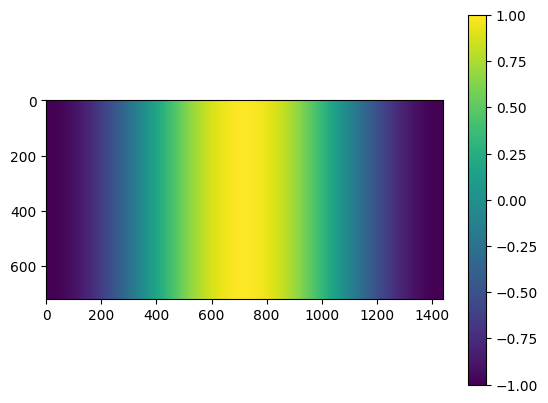

In [ ]:
cos_lon = torch.cos(deg2rad(lon))
cos_lon = cos_lon.view(1, 1, 1, lon.size(0))
cos_lon_mg = cos_lon.expand(1, 1, lat.size(0), lon.size(0))

plt.imshow(cos_lon_mg[0, 0])
plt.colorbar()
plt.show()

In [ ]:
outvar = torch.cat((cos_lat_mg, sin_lon_mg, cos_lon_mg), dim=1)
outvar.shape

torch.Size([1, 3, 721, 1440])

In [61]:
from modulus.utils.graphcast.data_utils import StaticData

static_data = StaticData(cfg.static_dataset_path, latitudes, longitudes).get()
static_data.shape

torch.Size([1, 5, 721, 1440])

---

## How does the data get fed to the model?

```python
@hydra.main(version_base="1.3", config_path="conf", config_name="config")
def main(cfg: DictConfig) -> None:
    ...
    while True:
        ...
        for _, data in enumerate(trainer.datapipe):
            ...
            # Prepare the input & output
            invar = data[0]["invar"]
            outvar = data[0]["outvar"]
            try:
                cos_zenith = data[0]["cos_zenith"]
            except KeyError:
                cos_zenith = None
            try:
                time_idx = data[0]["time_of_year_idx"].item()
            except KeyError:
                time_idx = None

            invar_cat = prepare_input(
                invar,
                cos_zenith,
                num_history=cfg.num_history,
                static_data=trainer.static_data,
                step=1,
                time_idx=time_idx,
                stride=cfg.stride,
                dt=cfg.dt,
                num_samples_per_year=cfg.num_samples_per_year_train,
                device=dist.device,
            )
            invar_cat = invar_cat.to(dtype=trainer.dtype)
            outvar = outvar.to(dtype=trainer.dtype)

            # training step
            loss = trainer.train(invar_cat, outvar)
            ...
```

Looking into `prepare_input()` from [1]:

```python
def prepare_input(
    invar,
    cos_zenith=None,
    num_history=0,
    static_data=None,
    step=None,
    time_idx=None,
    stride=1,
    dt=6.0,
    num_samples_per_year=1459,
    device="cuda",
):
    """Prepare input by adding history, cos zenith angle, and static data, if applicable"""

    # Add history
    if num_history > 0:
        # flatten the history dimension
        invar = invar.view(invar.size(0), -1, *(invar.size()[3:]))

    # Add cos zenith
    if cos_zenith is not None:
        cos_zenith = torch.squeeze(cos_zenith, dim=2)
        cos_zenith = torch.clamp(cos_zenith, min=0.0) - 1.0 / np.pi
        invar = torch.concat(
            (invar, cos_zenith[:, step - 1 : num_history + step, ...]), dim=1
        )

    # Add static data
    if static_data is not None:
        invar = torch.concat((invar, static_data), dim=1)

    # Add clock variables
    if time_idx is not None:
        # Precompute the tensors to concatenate
        sin_day_of_year = torch.zeros(1, num_history + 1, 721, 1440, device=device)
        cos_day_of_year = torch.zeros(1, num_history + 1, 721, 1440, device=device)
        sin_time_of_day = torch.zeros(1, num_history + 1, 721, 1440, device=device)
        cos_time_of_day = torch.zeros(1, num_history + 1, 721, 1440, device=device)

        for i in range(num_history + 1):
            # Calculate the adjusted time index
            adjusted_time_idx = (time_idx - i) % num_samples_per_year

            # Compute hour of the year and its decomposition into day of year and time of day
            hour_of_year = adjusted_time_idx * stride * dt
            day_of_year = hour_of_year // 24
            time_of_day = hour_of_year % 24

            # Normalize to the range [0, pi/2]
            normalized_day_of_year = torch.tensor(
                (day_of_year / 365) * (np.pi / 2), dtype=torch.float32, device=device
            )
            normalized_time_of_day = torch.tensor(
                (time_of_day / (24 - dt)) * (np.pi / 2),
                dtype=torch.float32,
                device=device,
            )

            # Fill the tensors for the current step
            sin_day_of_year[0, i] = torch.sin(normalized_day_of_year)
            cos_day_of_year[0, i] = torch.cos(normalized_day_of_year)
            sin_time_of_day[0, i] = torch.sin(normalized_time_of_day)
            cos_time_of_day[0, i] = torch.cos(normalized_time_of_day)

        # Concatenate the new channels to invar
        invar = torch.cat(
            (invar, sin_day_of_year, cos_day_of_year, sin_time_of_day, cos_time_of_day),
            dim=1,
        )

    return invar
```

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/examples/weather/graphcast/train_utils.py#L21

In [44]:
for _, data in enumerate(datapipe):
    print(len(data))
    print(data[0].keys())

    invar = data[0]["invar"]
    outvar = data[0]["outvar"]
    time_of_year_index = data[0]["time_of_year_idx"]
    cos_zenith = data[0]["cos_zenith"]
    break

print()
print("invar", invar.shape)
print("outvar", outvar.shape)
print("time_of_year_index", time_of_year_index.shape)
print("cos_zenigth", cos_zenith.shape)


1
dict_keys(['invar', 'cos_zenith', 'outvar', 'time_of_year_idx'])

invar torch.Size([1, 21, 721, 1440])
outvar torch.Size([1, 1, 21, 721, 1440])
time_of_year_index torch.Size([1, 1])
cos_zenigth torch.Size([1, 2, 1, 721, 1440])


In [52]:
cos_zenith1 = torch.squeeze(cos_zenith, dim=2)
cos_zenith1.shape, cos_zenith1, cos_zenith1.min(), cos_zenith1.max()

(torch.Size([1, 2, 721, 1440]),
 tensor([[[[ 0.3962,  0.3962,  0.3962,  ...,  0.3962,  0.3962,  0.3962],
           [ 0.3922,  0.3922,  0.3922,  ...,  0.3922,  0.3922,  0.3922],
           [ 0.3882,  0.3882,  0.3882,  ...,  0.3882,  0.3882,  0.3882],
           ...,
           [-0.4042, -0.4042, -0.4042,  ..., -0.4042, -0.4042, -0.4042],
           [-0.4002, -0.4002, -0.4002,  ..., -0.4002, -0.4002, -0.4002],
           [-0.3962, -0.3962, -0.3962,  ..., -0.3962, -0.3962, -0.3962]],
 
          [[ 0.3960,  0.3960,  0.3960,  ...,  0.3960,  0.3960,  0.3960],
           [ 0.3960,  0.3960,  0.3960,  ...,  0.3959,  0.3959,  0.3960],
           [ 0.3959,  0.3959,  0.3960,  ...,  0.3958,  0.3958,  0.3959],
           ...,
           [-0.3961, -0.3961, -0.3961,  ..., -0.3962, -0.3962, -0.3962],
           [-0.3961, -0.3961, -0.3961,  ..., -0.3961, -0.3961, -0.3961],
           [-0.3960, -0.3960, -0.3960,  ..., -0.3960, -0.3960, -0.3960]]]],
        device='cuda:0'),
 tensor(-1.0000, device='cud

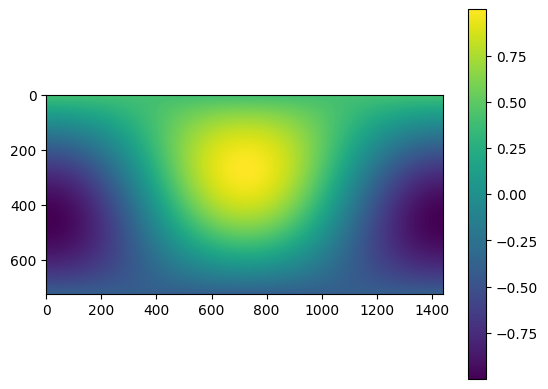

In [55]:
plt.imshow(cos_zenith1[0, 0].cpu())
plt.colorbar()
plt.show()

In [50]:
cos_zenith2 = torch.clamp(cos_zenith1, min=0.0) - 1.0 / np.pi
cos_zenith2.shape, cos_zenith2

(torch.Size([1, 2, 721, 1440]),
 tensor([[[[ 0.0779,  0.0779,  0.0779,  ...,  0.0779,  0.0779,  0.0779],
           [ 0.0739,  0.0739,  0.0739,  ...,  0.0739,  0.0739,  0.0739],
           [ 0.0699,  0.0699,  0.0699,  ...,  0.0699,  0.0699,  0.0699],
           ...,
           [-0.3183, -0.3183, -0.3183,  ..., -0.3183, -0.3183, -0.3183],
           [-0.3183, -0.3183, -0.3183,  ..., -0.3183, -0.3183, -0.3183],
           [-0.3183, -0.3183, -0.3183,  ..., -0.3183, -0.3183, -0.3183]],
 
          [[ 0.0777,  0.0777,  0.0777,  ...,  0.0777,  0.0777,  0.0777],
           [ 0.0777,  0.0777,  0.0777,  ...,  0.0776,  0.0776,  0.0776],
           [ 0.0776,  0.0776,  0.0777,  ...,  0.0775,  0.0775,  0.0776],
           ...,
           [-0.3183, -0.3183, -0.3183,  ..., -0.3183, -0.3183, -0.3183],
           [-0.3183, -0.3183, -0.3183,  ..., -0.3183, -0.3183, -0.3183],
           [-0.3183, -0.3183, -0.3183,  ..., -0.3183, -0.3183, -0.3183]]]],
        device='cuda:0'))

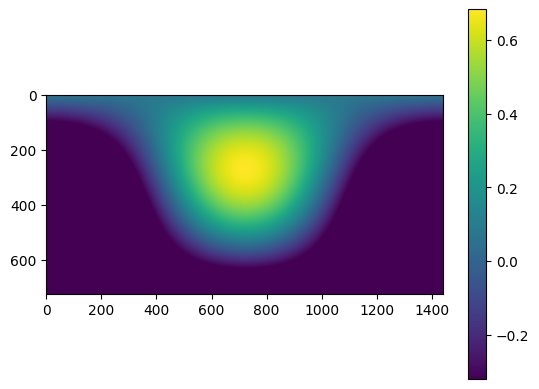

In [54]:
plt.imshow(cos_zenith2[0, 0].cpu())
plt.colorbar()
plt.show()

In [58]:
# mock
step = 1

print(step - 1, num_history + step)
cos_zenith2[:, step - 1 : num_history + step, ...].shape

0 1


torch.Size([1, 1, 721, 1440])

In [65]:
print(invar.shape)
invar1 = torch.concat((invar, cos_zenith2[:, step - 1 : num_history + step, ...]), dim=1)
invar1 = invar1.to("cpu")
print(invar1.shape)

torch.Size([1, 21, 721, 1440])
torch.Size([1, 22, 721, 1440])


In [68]:
print(static_data.shape)
invar2 = torch.concat((invar1, static_data), dim=1)
invar2.shape

torch.Size([1, 5, 721, 1440])


torch.Size([1, 27, 721, 1440])

In [87]:
from train_utils import prepare_input

invar_cat = prepare_input(
    invar,
    cos_zenith,
    num_history=0,
    static_data=static_data.to("cuda"),
    step=1,
    time_idx=time_of_year_index.item(),
    stride=1,
    dt=6.0,
    num_samples_per_year=cfg.num_samples_per_year_train,
)

invar_cat.shape

torch.Size([1, 31, 721, 1440])